In [1]:
import sqlite3
from pathlib import Path

__file__ = %pwd
DATA = Path(__file__).parent.parent / "data"
PRIORITIES = DATA / "Priorities"
DATABASE = DATA / "databases" / "exploration.db"

import sys
sys.path.append(str(DATA.parent))  # Add the parent directory of 'modeling' to the Python path

con = sqlite3.connect(DATABASE)
cur = con.cursor()

In [2]:
import pandas as pd
import numpy as np


def filter_academic_year(df, year):
    """Filter dataframe by academic year and drop Year column"""
    filtered_df = df[df["AcademicYear"] == year].copy()
    return filtered_df.drop(columns=["Year"])


def standardize_acgr_columns(acgr_df, mapping):
    """Rename ACGR columns to match Census Day naming convention"""
    renamed_df = acgr_df.copy()
    new_columns = {}

    for col in acgr_df.columns:
        parts = col.split(".")
        if len(parts) == 2 and parts[1] in mapping:
            new_col = f"{parts[0]}.{mapping[parts[1]]}"
            new_columns[col] = new_col

    return renamed_df.rename(columns=new_columns)


acgr_to_census_mapping = {
    # Race/Ethnicity
    "RB": "RE_B",  # African American
    "RI": "RE_I",  # American Indian or Alaska Native
    "RA": "RE_A",  # Asian
    "RF": "RE_F",  # Filipino
    "RH": "RE_H",  # Hispanic or Latino
    "RD": "RE_D",  # Not Reported
    "RP": "RE_P",  # Pacific Islander
    "RT": "RE_T",  # Two or More Races
    "RW": "RE_W",  # White
    # Gender
    "GM": "GN_M",  # Male
    "GF": "GN_F",  # Female
    "GX": "GN_X",  # Non-Binary
    "GZ": "GN_Z",  # Missing Gender
    # Student Groups
    "SE": "SG_EL",  # English Learners
    "SD": "SG_DS",  # Students with Disabilities
    "SS": "SG_SD",  # Socioeconomically Disadvantaged
    "SM": "SG_MG",  # Migrant
    "SF": "SG_FS",  # Foster
    "SH": "SG_HM",  # Homeless
    # Total
    "TA": "TA",  # Total
}

In [ ]:
census_day = pd.read_sql_query("SELECT * FROM CensusDayWide", con)
acgr = pd.read_sql_query("SELECT * FROM ACGRWide Where CharterSchool = 'No '", con)

acgr_standardized = standardize_acgr_columns(acgr, acgr_to_census_mapping)

acgr_standardized = acgr_standardized[
    acgr_standardized["Year"].isin(census_day["AcademicYear"].unique())
]

merged = pd.merge(
    census_day,
    acgr_standardized,
    left_on=[
        "AggregateLevel",
        "CountyCode",
        "DistrictCode",
        "SchoolCode",
        "AcademicYear",
    ],
    right_on=["AggregateLevel", "CountyCode", "DistrictCode", "SchoolCode", "Year"],
    how="outer",
    indicator=True,
)

In [ ]:
for col in merged.columns:
    if any(substr in col for substr in ["Rate", "Percent", "ENR", "GR_"]):
        merged[col] = pd.to_numeric(merged[col], errors="coerce")

academic_years = [
    "2017-18",
    "2018-19",
    "2019-20",
    "2020-21",
    "2021-22",
    "2022-23",
    "2023-24",
]

grad_rate_columns_to_drop = [
    col
    for col in merged.columns
    if col.startswith("RegHSDiploma") or col.startswith("Dropout")
]
csu_rate_columns_to_drop = [col for col in merged.columns if col.startswith("UniReqs")]

year_df_mapping = {year: filter_academic_year(merged, year) for year in academic_years}

# XGBoost


### Cross Validated Grad Rate


In [4]:
from modeling.utils.xgboost import cross_validate_xgboost, plot_cv_feature_importance
from modeling.utils.xgboost import (
    plot_top_k_features,
    plot_feature_avg_variance,
    plot_feature_time_series,
)

cv_xgb_models = {}

target_column = "RegHSDiplomaRate.TA"

for year, year_df in year_df_mapping.items():

    cv_result = cross_validate_xgboost(
        df=year_df,
        target_column=target_column,
        columns_to_drop=[target_column] + grad_rate_columns_to_drop,
        n_splits=5,
        print_results=True,
        n_jobs=-1,
    )

    cv_xgb_models[year] = cv_result

Cross-Validation Results for RegHSDiplomaRate.TA (5 folds) for 2017-18:
RMSE: 4.7829 ± 0.8335
MAE: 2.3216 ± 0.1176
R^2: 0.9663 ± 0.0095
Cross-Validation Results for RegHSDiplomaRate.TA (5 folds) for 2018-19:
RMSE: 3.7437 ± 0.3672
MAE: 2.0004 ± 0.1241
R^2: 0.9758 ± 0.0050
Cross-Validation Results for RegHSDiplomaRate.TA (5 folds) for 2019-20:
RMSE: 4.8888 ± 0.5480
MAE: 2.3869 ± 0.2133
R^2: 0.9631 ± 0.0085
Cross-Validation Results for RegHSDiplomaRate.TA (5 folds) for 2020-21:
RMSE: 4.9849 ± 0.2344
MAE: 2.4072 ± 0.1677
R^2: 0.9601 ± 0.0052
Cross-Validation Results for RegHSDiplomaRate.TA (5 folds) for 2021-22:
RMSE: 8.5128 ± 1.0030
MAE: 4.2636 ± 0.2934
R^2: 0.8135 ± 0.0426
Cross-Validation Results for RegHSDiplomaRate.TA (5 folds) for 2022-23:
RMSE: 9.1846 ± 1.3557
MAE: 4.7756 ± 0.4648
R^2: 0.7900 ± 0.0431
Cross-Validation Results for RegHSDiplomaRate.TA (5 folds) for 2023-24:
RMSE: 10.5811 ± 0.8835
MAE: 6.4697 ± 0.4206
R^2: 0.6990 ± 0.0354


<Figure size 1400x600 with 0 Axes>

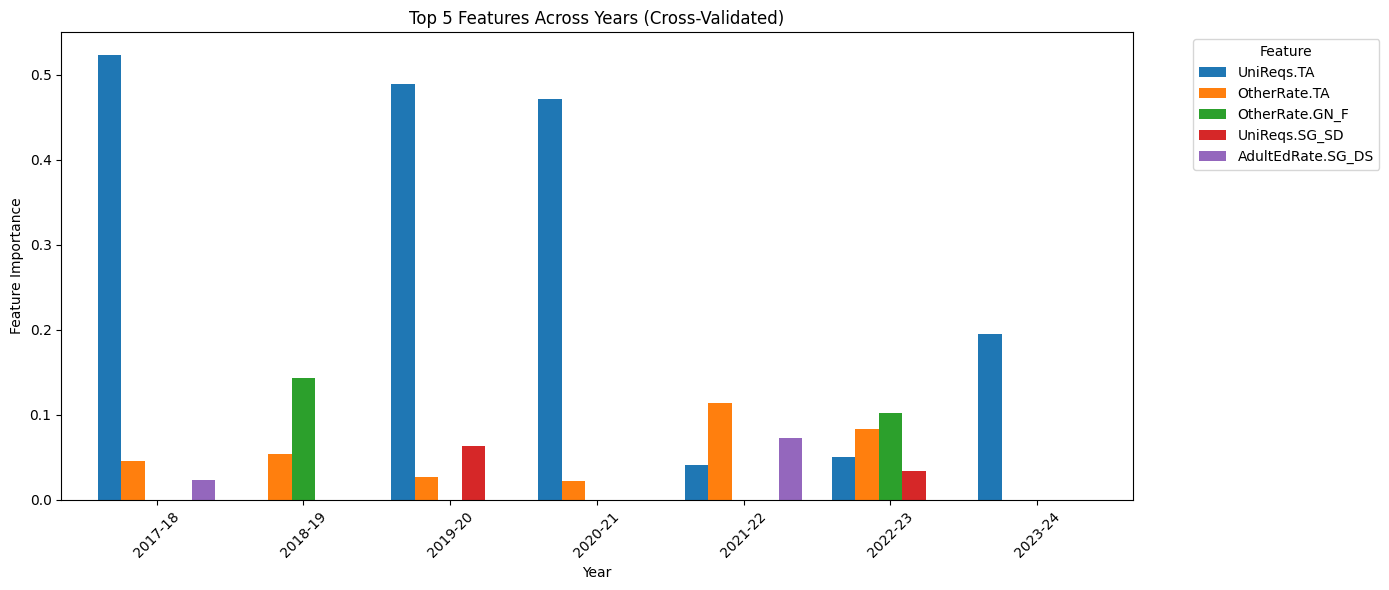

<Figure size 1400x600 with 0 Axes>

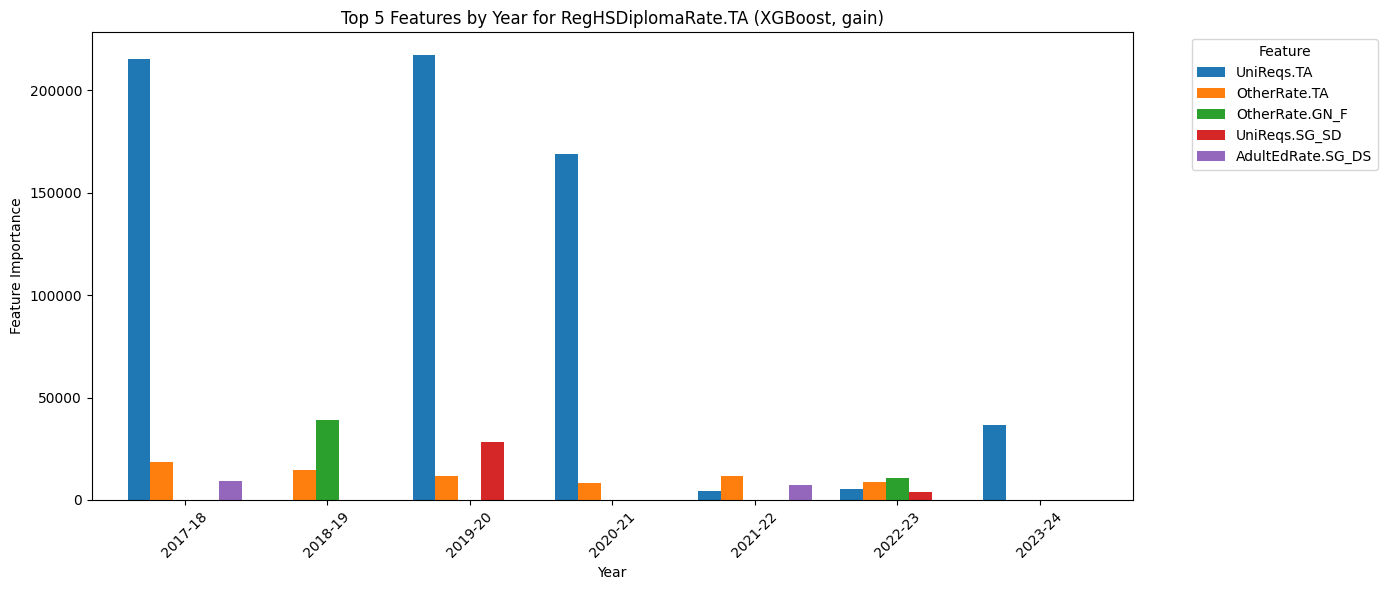

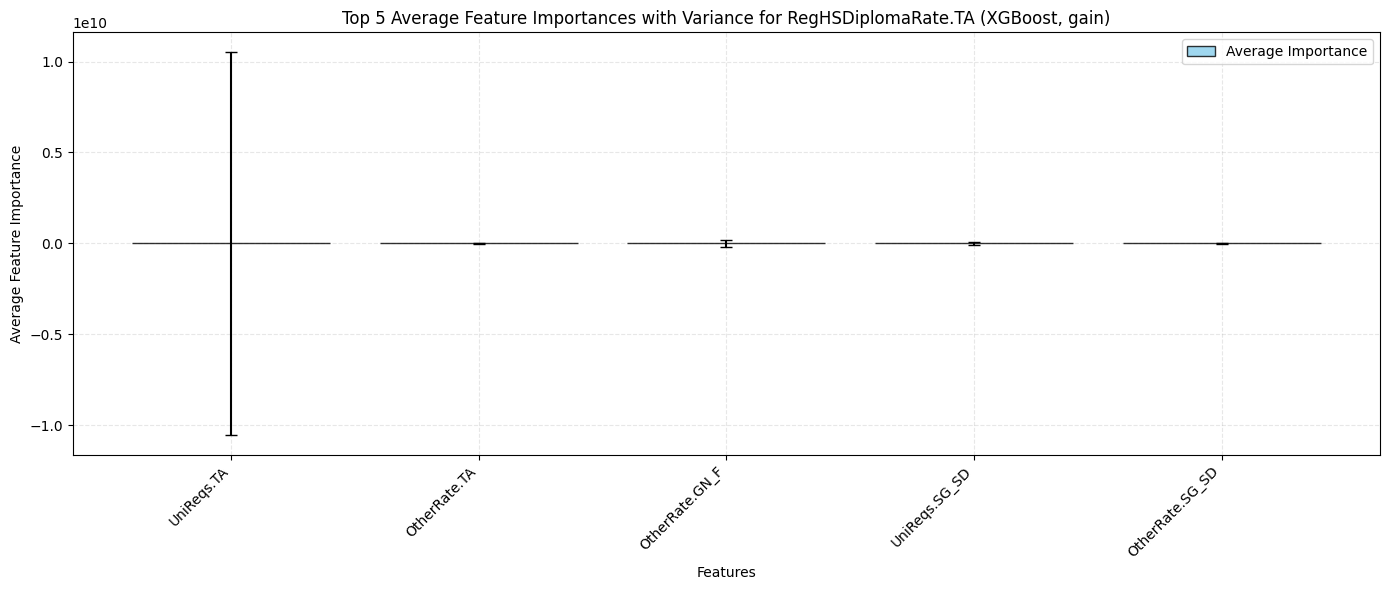

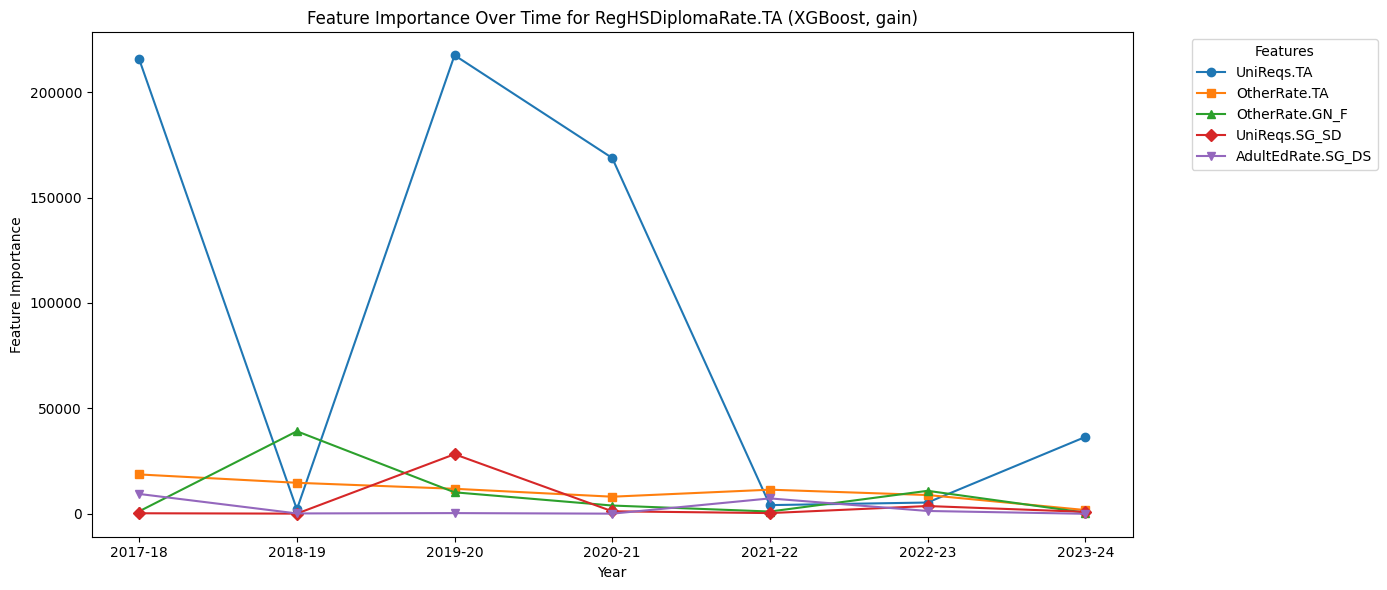

In [5]:
top_features = plot_cv_feature_importance(cv_xgb_models, top_n=5)
plot_top_k_features(cv_xgb_models, "XGBoost", "gain", target_column, k=5)
plot_feature_avg_variance(cv_xgb_models, "XGBoost", "gain", target_column)
plot_feature_time_series(
    cv_xgb_models, "XGBoost", "gain", target_column, top_features[:5]
)

### Cross Validated CSU/UC Readiness Rate


In [6]:
from modeling.utils.xgboost import cross_validate_xgboost, plot_cv_feature_importance
from modeling.utils.xgboost import (
    plot_top_k_features,
    plot_feature_avg_variance,
    plot_feature_time_series,
)

cv_xgb_models = {}

target_column = "UniReqsPercent.TA"

for year, year_df in year_df_mapping.items():

    cv_result = cross_validate_xgboost(
        df=year_df,
        target_column=target_column,
        columns_to_drop=[target_column] + csu_rate_columns_to_drop,
        n_splits=5,
        print_results=True,
        n_jobs=-1,
    )

    cv_xgb_models[year] = cv_result

Cross-Validation Results for UniReqsPercent.TA (5 folds) for 2017-18:
RMSE: 6.7164 ± 0.6558
MAE: 3.8501 ± 0.1973
R^2: 0.9446 ± 0.0108
Cross-Validation Results for UniReqsPercent.TA (5 folds) for 2018-19:
RMSE: 6.9513 ± 0.6708
MAE: 4.2041 ± 0.2569
R^2: 0.9407 ± 0.0112
Cross-Validation Results for UniReqsPercent.TA (5 folds) for 2019-20:
RMSE: 6.6416 ± 0.9580
MAE: 3.7232 ± 0.2153
R^2: 0.9474 ± 0.0176
Cross-Validation Results for UniReqsPercent.TA (5 folds) for 2020-21:
RMSE: 6.9604 ± 1.0092
MAE: 4.0997 ± 0.3003
R^2: 0.9406 ± 0.0165
Cross-Validation Results for UniReqsPercent.TA (5 folds) for 2021-22:
RMSE: 11.5296 ± 0.6045
MAE: 7.7116 ± 0.4044
R^2: 0.8412 ± 0.0221
Cross-Validation Results for UniReqsPercent.TA (5 folds) for 2022-23:
RMSE: 12.9792 ± 0.3978
MAE: 8.4135 ± 0.2563
R^2: 0.8099 ± 0.0099
Cross-Validation Results for UniReqsPercent.TA (5 folds) for 2023-24:
RMSE: 12.4660 ± 1.5072
MAE: 8.2197 ± 0.6976
R^2: 0.8188 ± 0.0360


<Figure size 1400x600 with 0 Axes>

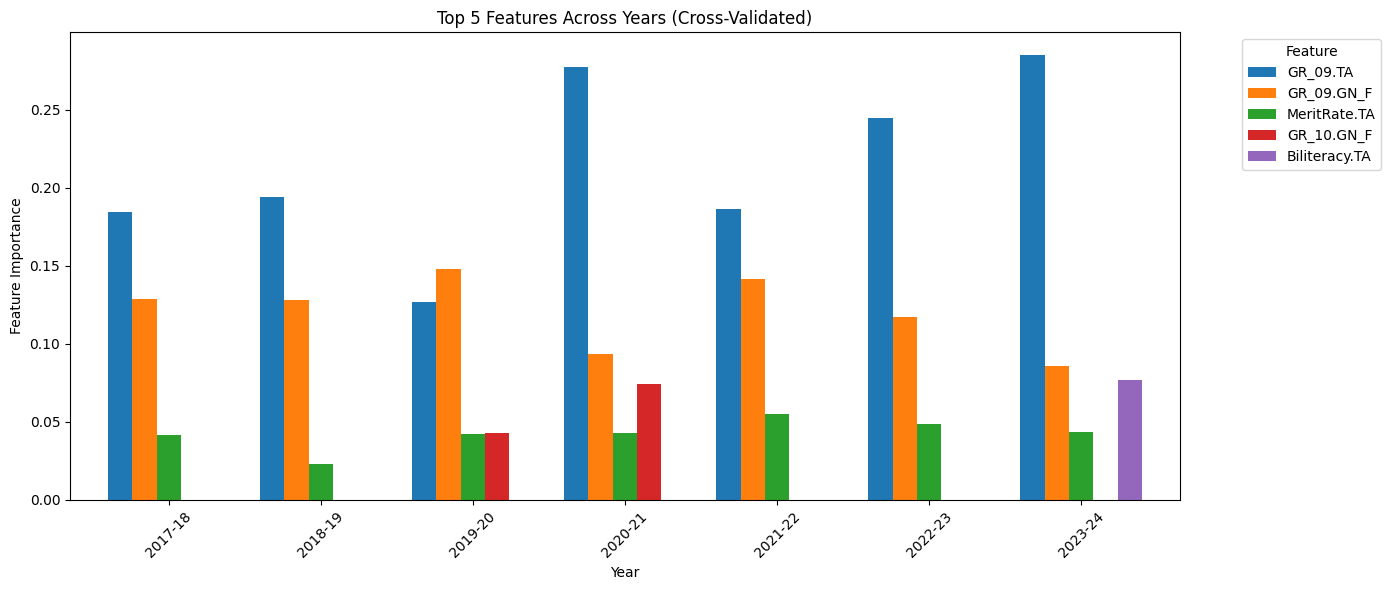

<Figure size 1400x600 with 0 Axes>

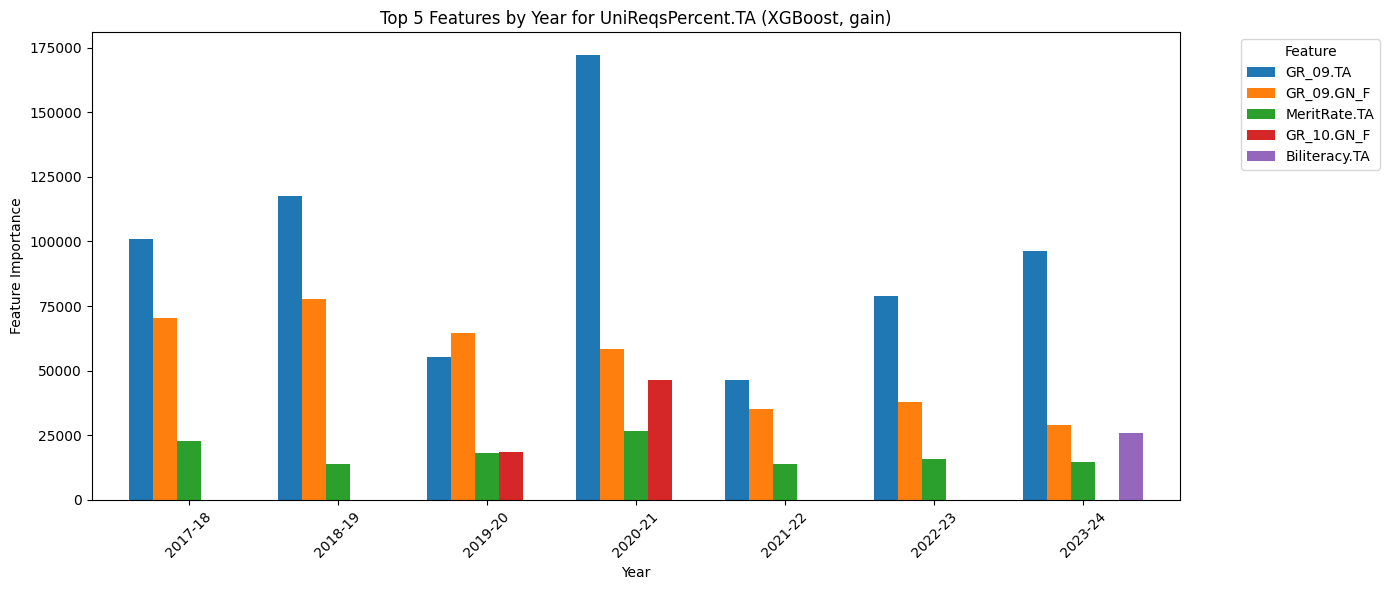

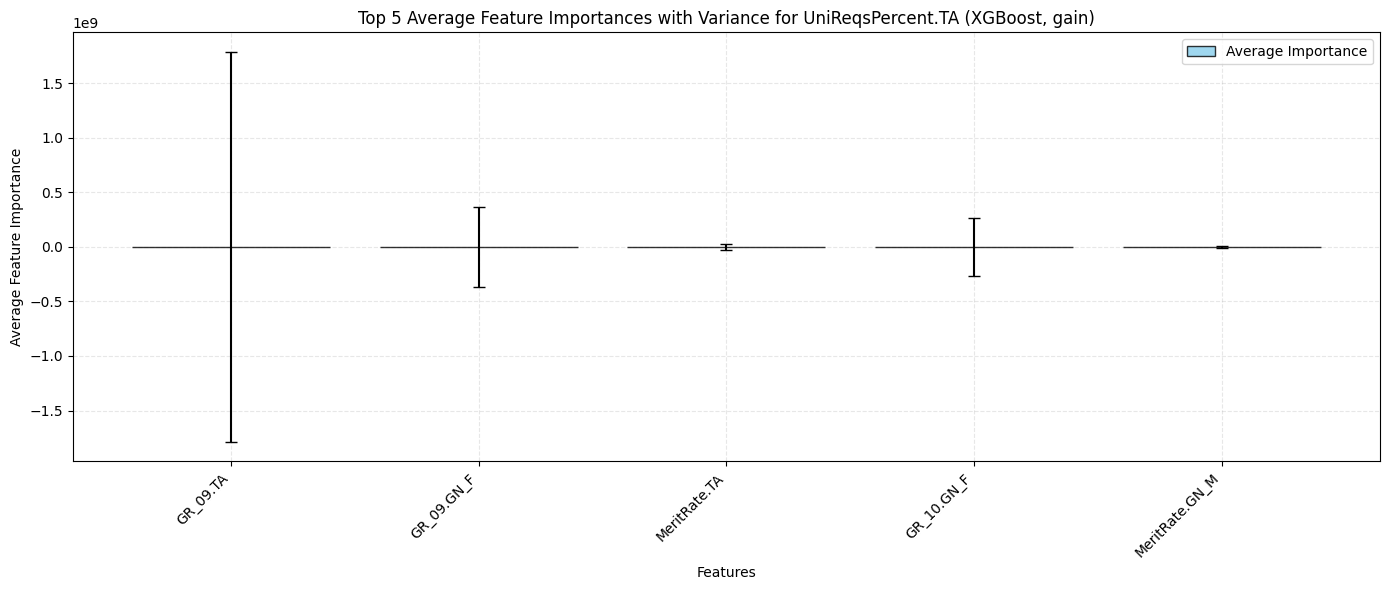

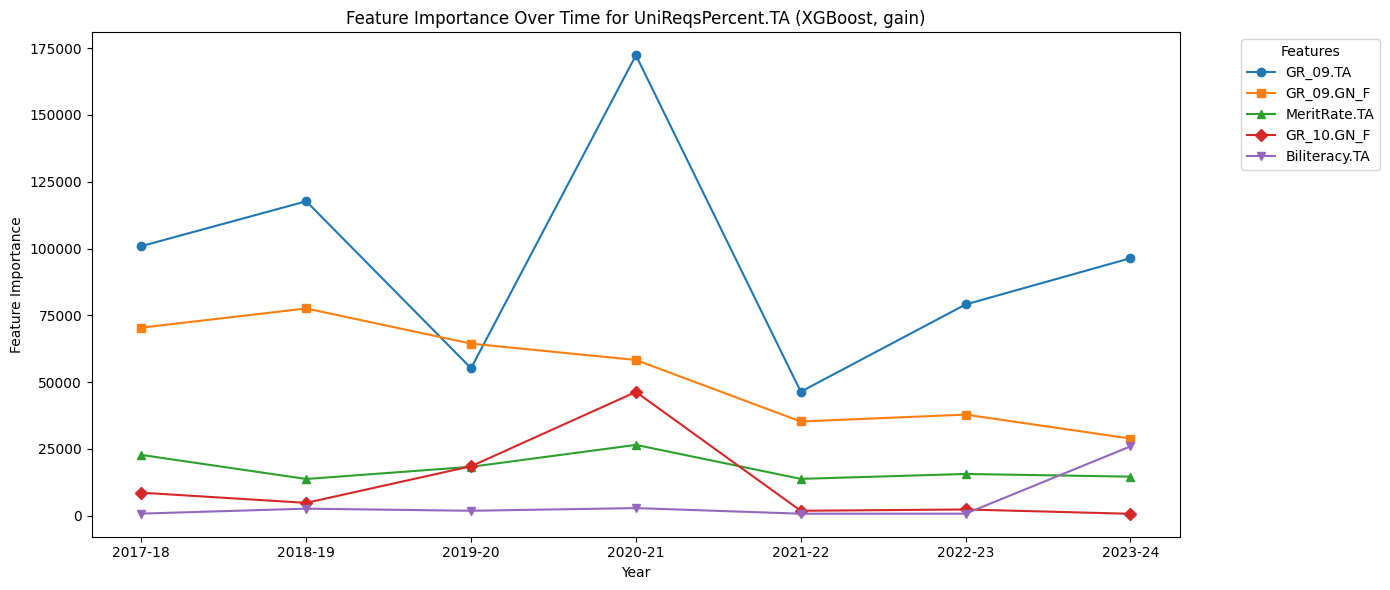

In [7]:
top_features = plot_cv_feature_importance(cv_xgb_models, top_n=5)
plot_top_k_features(cv_xgb_models, "XGBoost", "gain", target_column, k=5)
plot_feature_avg_variance(cv_xgb_models, "XGBoost", "gain", target_column)
plot_feature_time_series(
    cv_xgb_models, "XGBoost", "gain", target_column, top_features[:5]
)

### Non Cross Validated Grad Rate


In [8]:
import modeling.utils.xgboost as xgb

grad_rate = "RegHSDiplomaRate.TA"
xgb_model = "XGBoost"

all_grad_rate_models = {}
for year, df in year_df_mapping.items():
    all_grad_rate_models[year] = xgb.train_xgboost_model(
        df, grad_rate, grad_rate_columns_to_drop, print_plot=False
    )

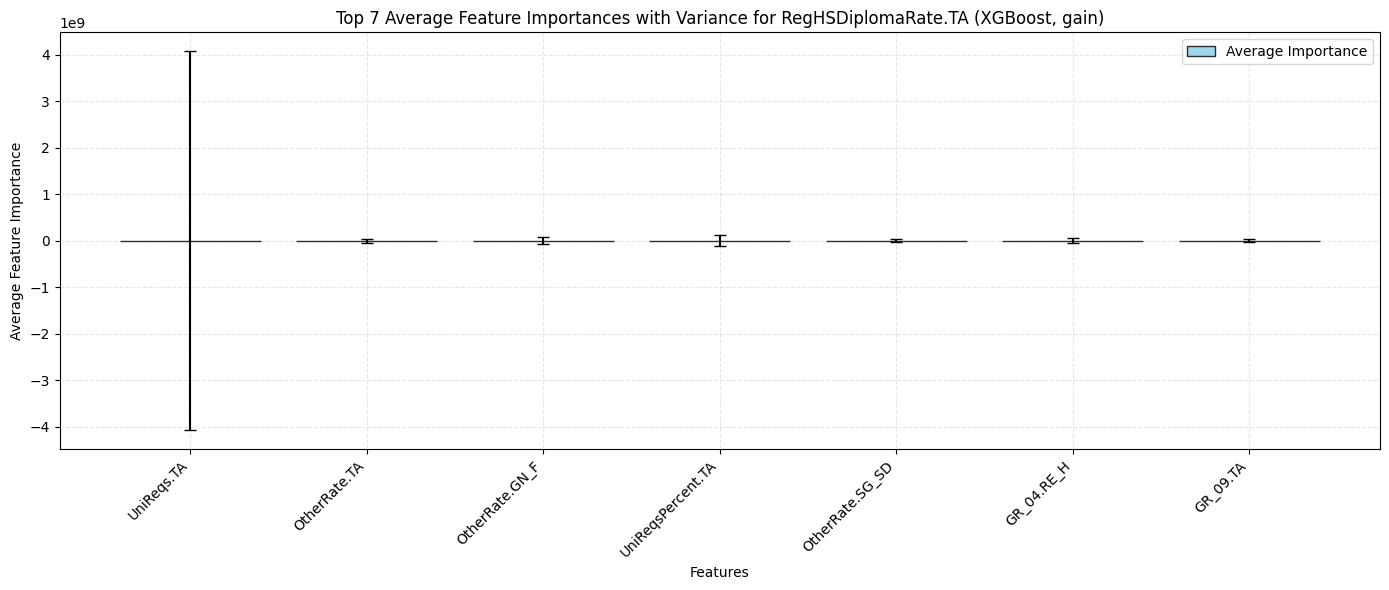

<Figure size 1400x600 with 0 Axes>

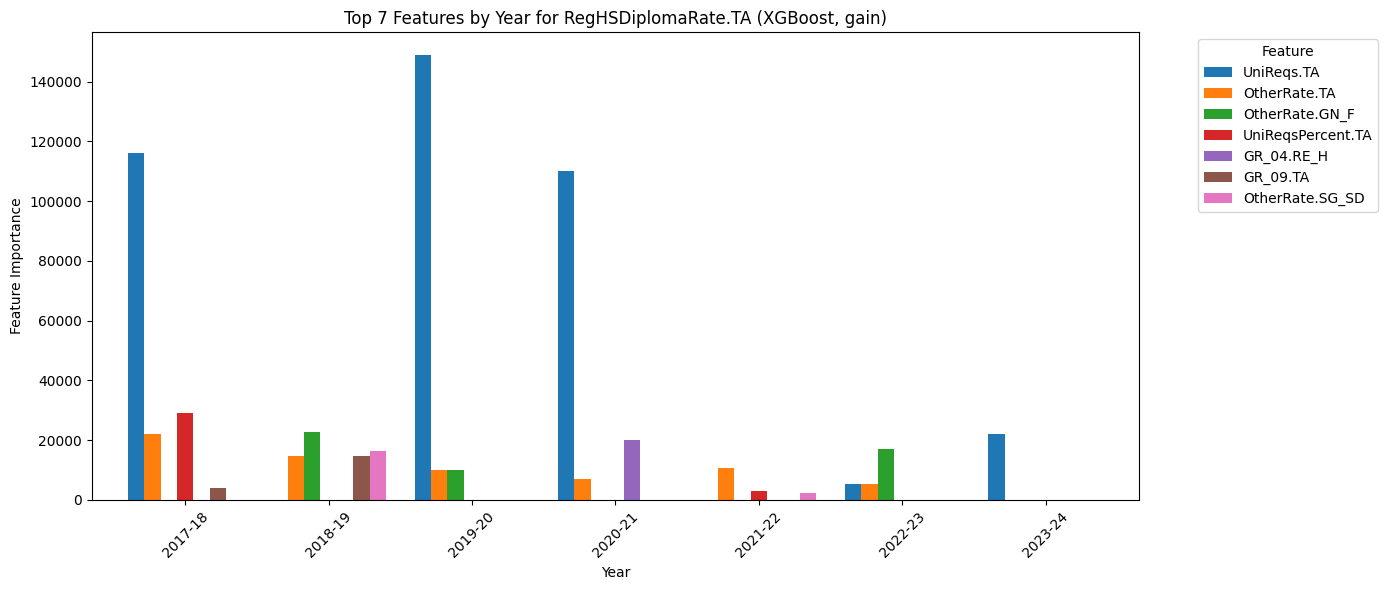

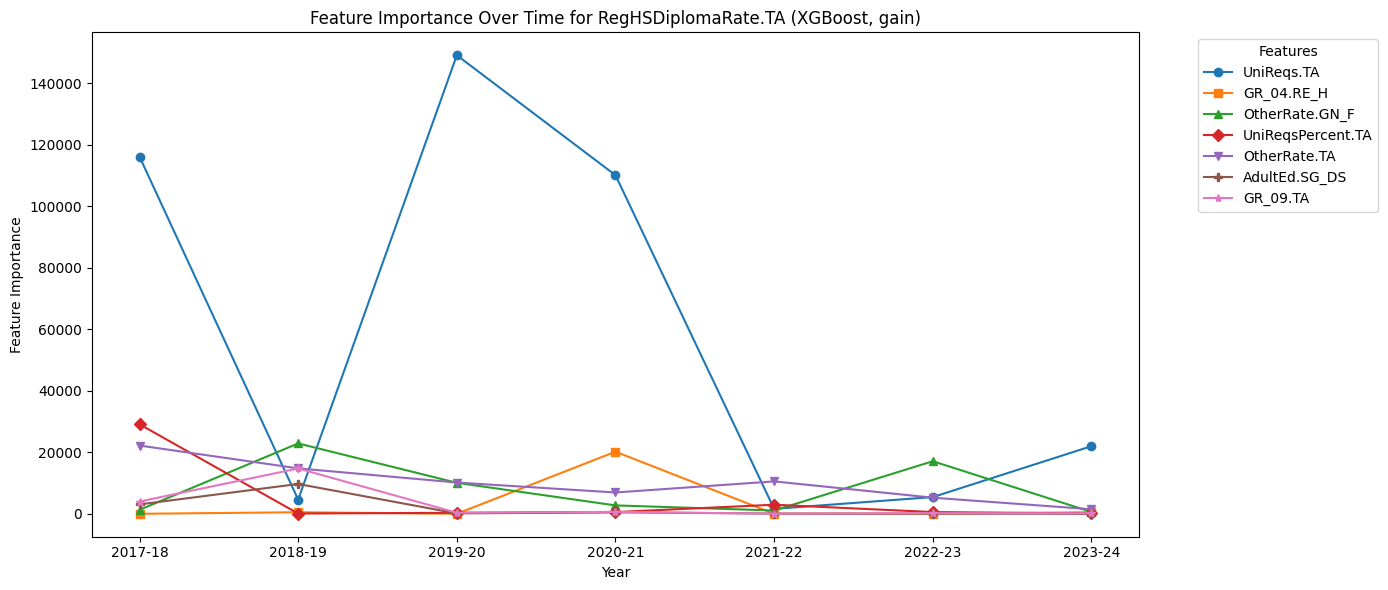

In [9]:
xgb.plot_feature_avg_variance(all_grad_rate_models, xgb_model, "gain", grad_rate, k=7)
top_k_features = xgb.plot_top_k_features(
    all_grad_rate_models, xgb_model, "gain", grad_rate, k=7
)
xgb.plot_feature_time_series(
    all_grad_rate_models, xgb_model, "gain", grad_rate, top_k_features
)

### Non Cross Validated CSU/UC Readiness Rate


In [10]:
uc_csu_rate = "UniReqsPercent.TA"
xgb_model = "XGBoost"

all_csu_rate_models = {}
for year, df in year_df_mapping.items():
    all_csu_rate_models[year] = xgb.train_xgboost_model(
        df, grad_rate, csu_rate_columns_to_drop, print_plot=False
    )

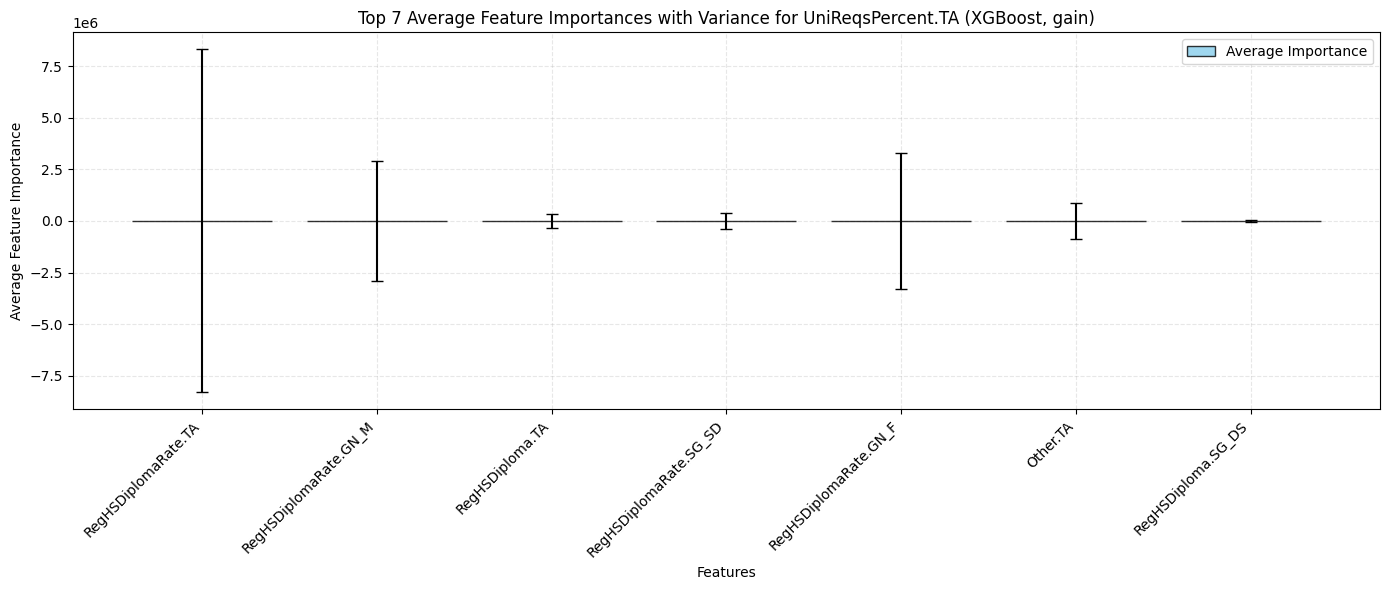

<Figure size 1400x600 with 0 Axes>

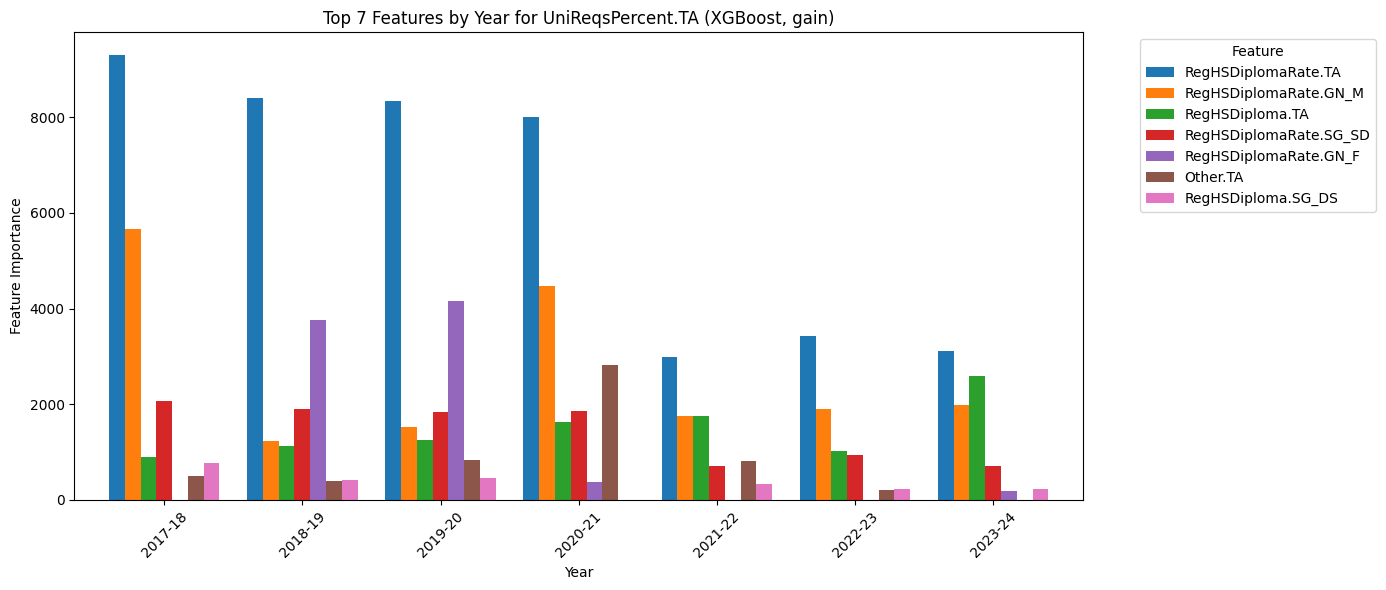

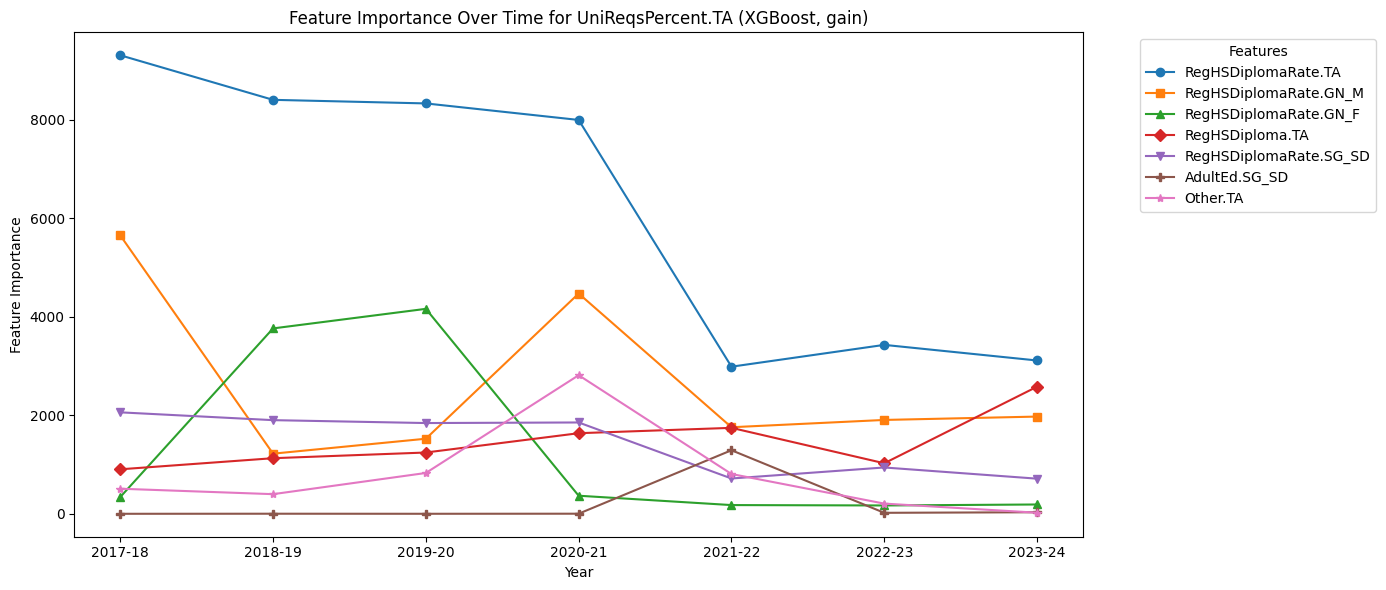

In [11]:
xgb.plot_feature_avg_variance(all_csu_rate_models, xgb_model, "gain", uc_csu_rate, k=7)
top_k_features = xgb.plot_top_k_features(
    all_csu_rate_models, xgb_model, "gain", uc_csu_rate, k=7
)
xgb.plot_feature_time_series(
    all_csu_rate_models, xgb_model, "gain", uc_csu_rate, top_k_features
)

# Random Forest


### Cross Validated Grad Rate


In [12]:
from modeling.utils.randomforest import (
    cross_validate_random_forest,
    plot_cv_feature_importance_rf,
    plot_top_k_features_rf,
    plot_feature_avg_variance_rf,
    plot_feature_time_series_rf,
)

cv_models = {}

target_variable = "RegHSDiplomaRate.TA"
years = list(year_df_mapping.keys())

for year in years:
    df = year_df_mapping[year]

    cv_result = cross_validate_random_forest(
        df=df,
        target_column=target_variable,
        columns_to_drop=grad_rate_columns_to_drop,
        n_splits=5,
        print_results=True,
        n_jobs=-1,
    )

    cv_models[year] = cv_result

Cross-Validation Results for RegHSDiplomaRate.TA (5 folds) for 2017-18:
RMSE: 5.4446 ± 0.7152
MAE: 2.8058 ± 0.1212
R²: 0.9557 ± 0.0103
Cross-Validation Results for RegHSDiplomaRate.TA (5 folds) for 2018-19:
RMSE: 5.0823 ± 0.4429
MAE: 2.6252 ± 0.1588
R²: 0.9572 ± 0.0073
Cross-Validation Results for RegHSDiplomaRate.TA (5 folds) for 2019-20:
RMSE: 5.9152 ± 0.4737
MAE: 3.0193 ± 0.1646
R²: 0.9432 ± 0.0098
Cross-Validation Results for RegHSDiplomaRate.TA (5 folds) for 2020-21:
RMSE: 5.8378 ± 0.2656
MAE: 3.0568 ± 0.1500
R²: 0.9413 ± 0.0051
Cross-Validation Results for RegHSDiplomaRate.TA (5 folds) for 2021-22:
RMSE: 9.3411 ± 1.2453
MAE: 4.5942 ± 0.1782
R²: 0.7763 ± 0.0659
Cross-Validation Results for RegHSDiplomaRate.TA (5 folds) for 2022-23:
RMSE: 9.9216 ± 1.6112
MAE: 5.1455 ± 0.5509
R²: 0.7619 ± 0.0540
Cross-Validation Results for RegHSDiplomaRate.TA (5 folds) for 2023-24:
RMSE: 10.7708 ± 1.2020
MAE: 6.5633 ± 0.5324
R²: 0.6931 ± 0.0569


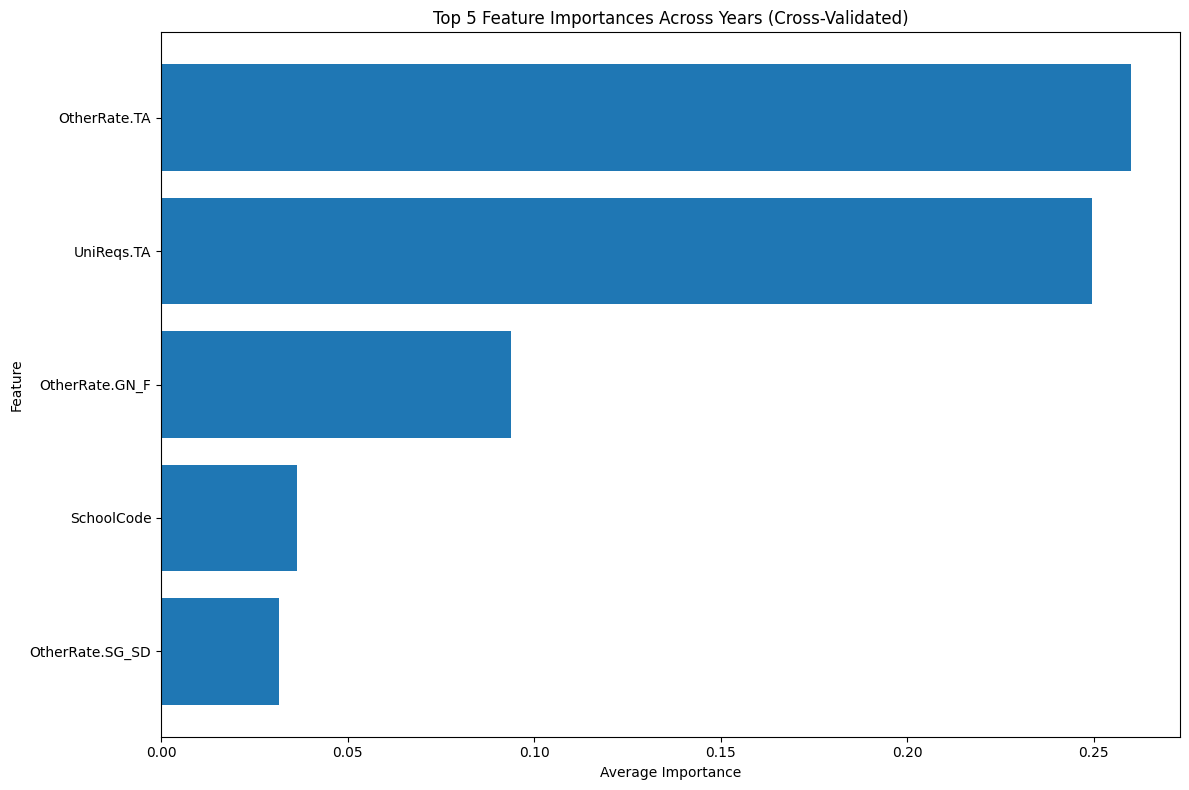

<Figure size 1400x600 with 0 Axes>

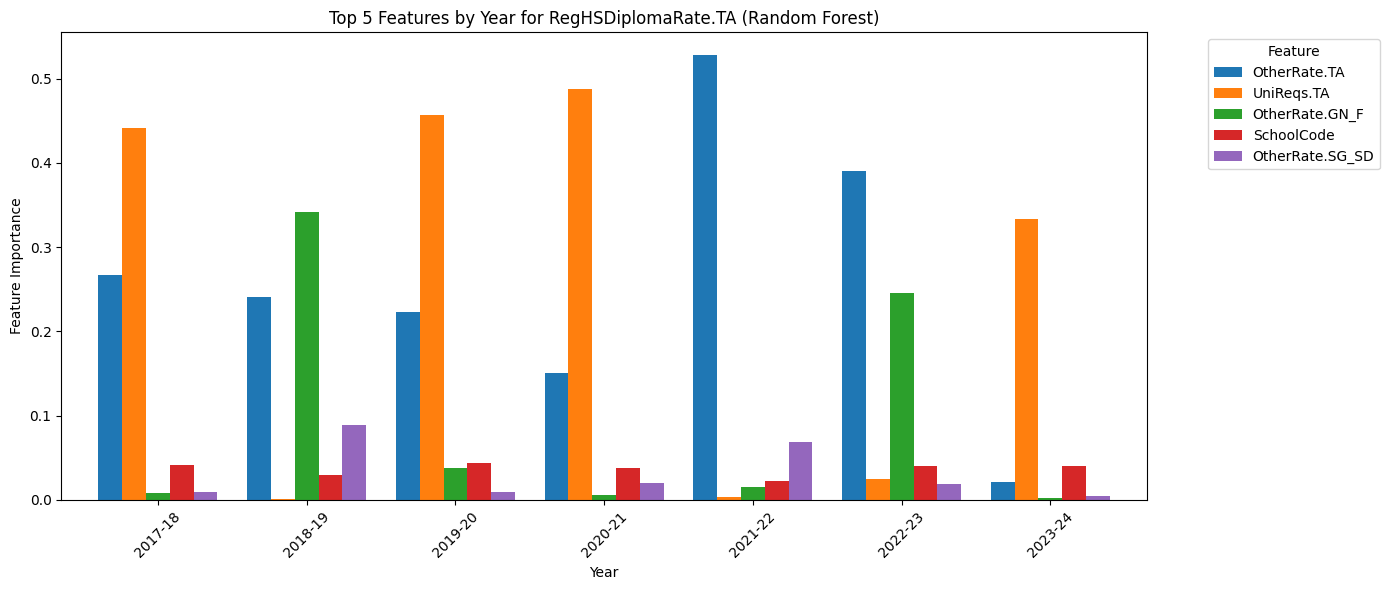

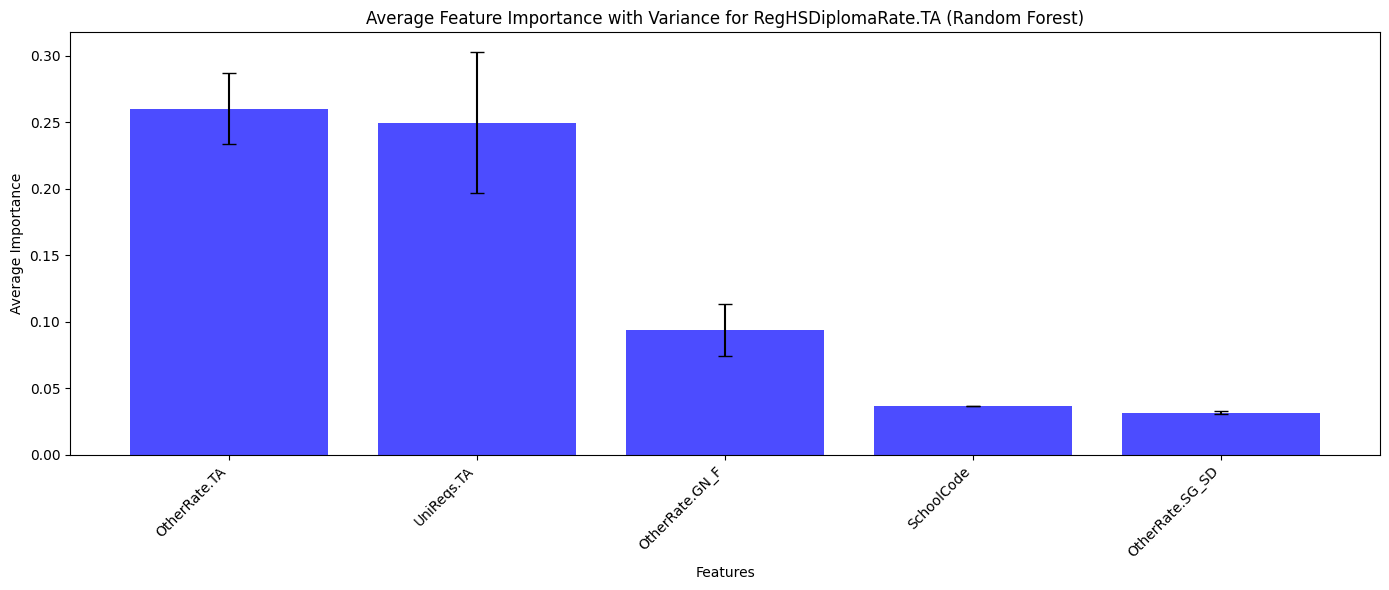

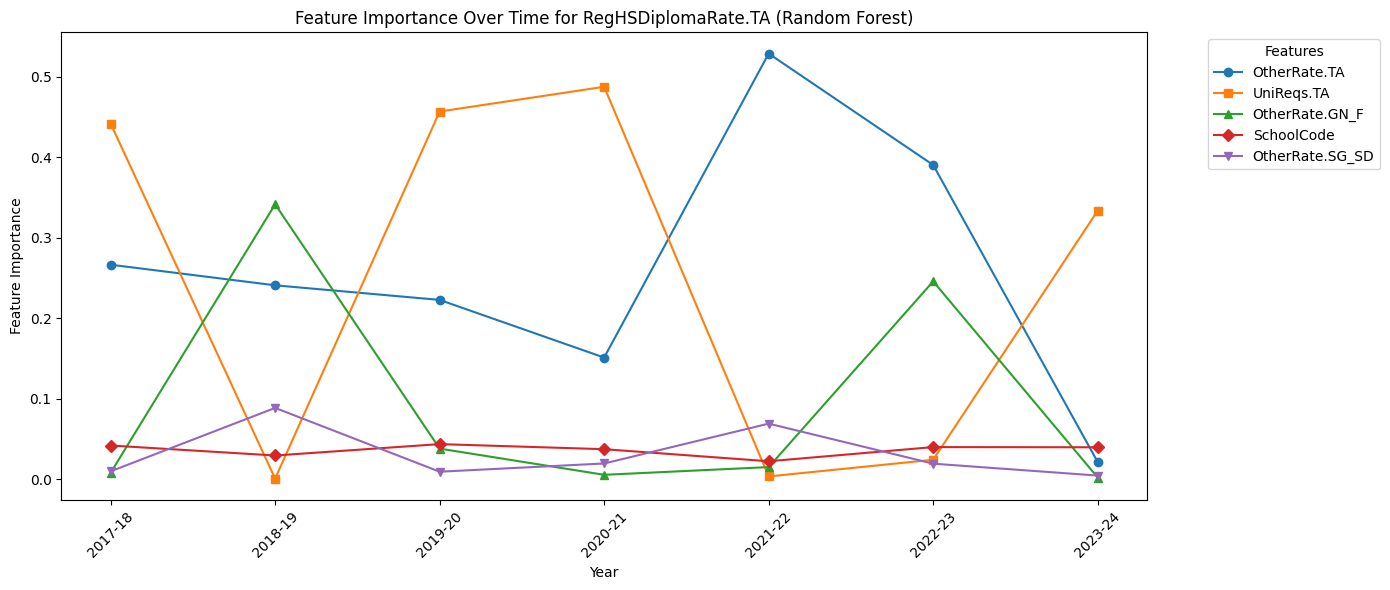

In [13]:
all_top_features = plot_cv_feature_importance_rf(cv_models, top_n=5)

plot_top_k_features_rf(cv_models, target_variable=target_variable, k=5)
plot_feature_avg_variance_rf(
    cv_models, target_variable=target_variable, top_k_features=all_top_features[:5]
)
plot_feature_time_series_rf(
    cv_models, target_variable=target_variable, top_k_features=all_top_features[:5]
)

### Cross Validated CSU/UC Readiness Rate


In [26]:
from modeling.utils.randomforest import (
    cross_validate_random_forest,
    plot_cv_feature_importance_rf,
    plot_top_k_features_rf,
    plot_feature_avg_variance_rf,
    plot_feature_time_series_rf,
)

cv_models = {}

target_variable = "UniReqsPercent.TA"
years = list(year_df_mapping.keys())

for year in years:
    df = year_df_mapping[year]

    cv_result = cross_validate_random_forest(
        df=df,
        target_column=target_variable,
        columns_to_drop=csu_rate_columns_to_drop,
        n_splits=5,
        print_results=True,
        n_jobs=-1,
    )

    cv_models[year] = cv_result

Cross-Validation Results for UniReqsPercent.TA (5 folds) for 2017-18:
RMSE: 7.2710 ± 0.5416
MAE: 4.2416 ± 0.1704
R²: 0.9342 ± 0.0088
Cross-Validation Results for UniReqsPercent.TA (5 folds) for 2018-19:
RMSE: 7.7662 ± 0.7395
MAE: 4.5816 ± 0.3245
R²: 0.9261 ± 0.0144
Cross-Validation Results for UniReqsPercent.TA (5 folds) for 2019-20:
RMSE: 7.2279 ± 0.9839
MAE: 4.1052 ± 0.2305
R²: 0.9341 ± 0.0166
Cross-Validation Results for UniReqsPercent.TA (5 folds) for 2020-21:
RMSE: 7.5809 ± 0.8614
MAE: 4.4599 ± 0.2276
R²: 0.9307 ± 0.0167
Cross-Validation Results for UniReqsPercent.TA (5 folds) for 2021-22:
RMSE: 11.7719 ± 0.5408
MAE: 7.9964 ± 0.3193
R²: 0.8334 ± 0.0188
Cross-Validation Results for UniReqsPercent.TA (5 folds) for 2022-23:
RMSE: 13.2140 ± 0.1420
MAE: 8.7613 ± 0.2963
R²: 0.7996 ± 0.0047
Cross-Validation Results for UniReqsPercent.TA (5 folds) for 2023-24:
RMSE: 12.9302 ± 1.4513
MAE: 8.6881 ± 0.5815
R²: 0.8036 ± 0.0390


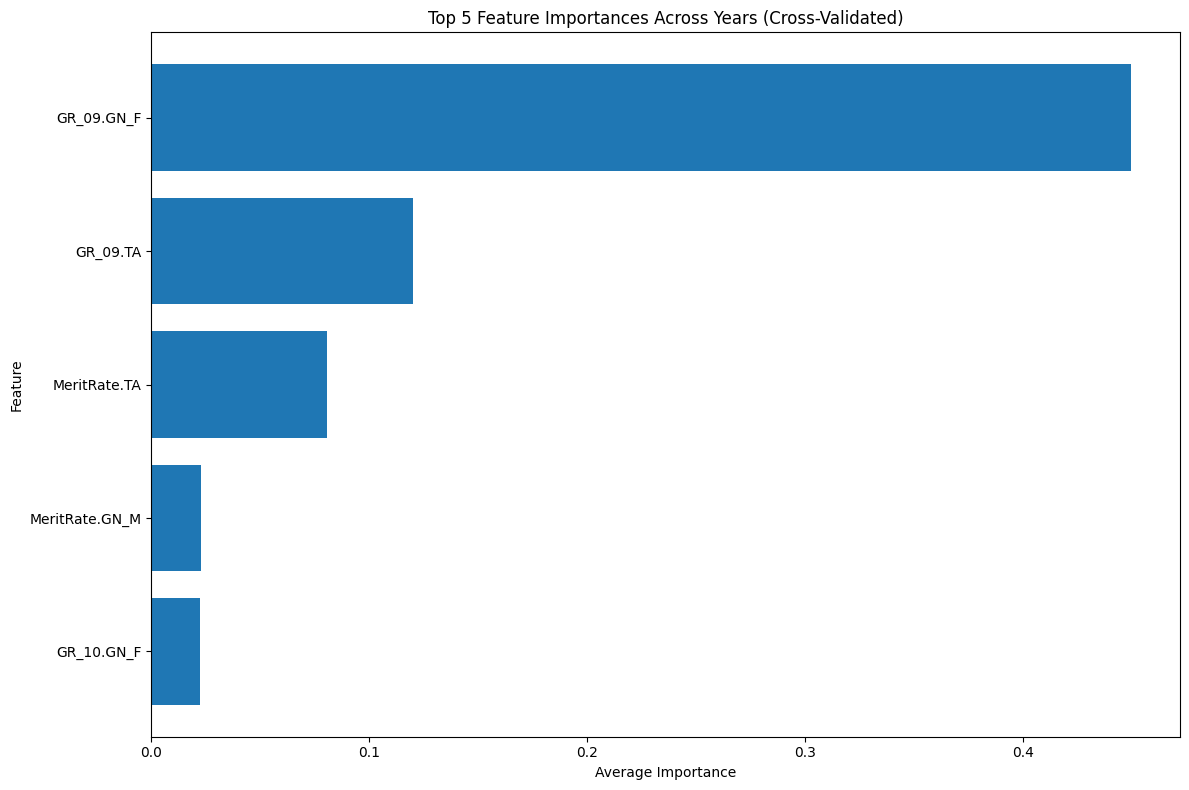

<Figure size 1400x600 with 0 Axes>

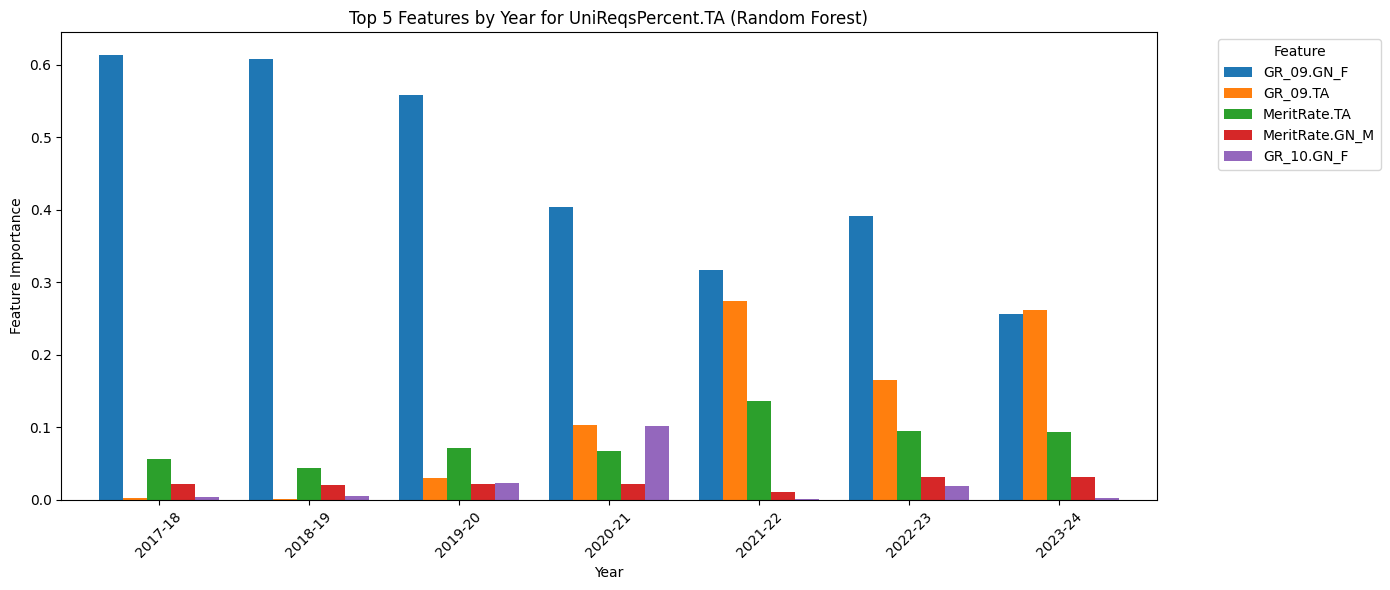

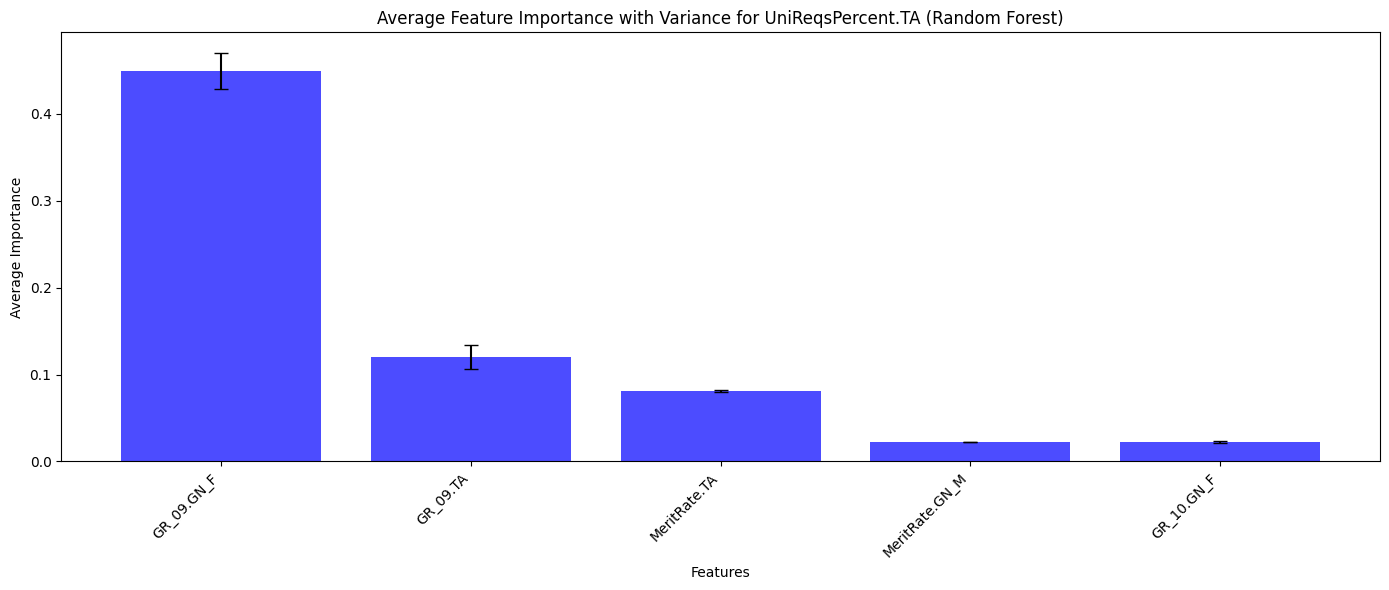

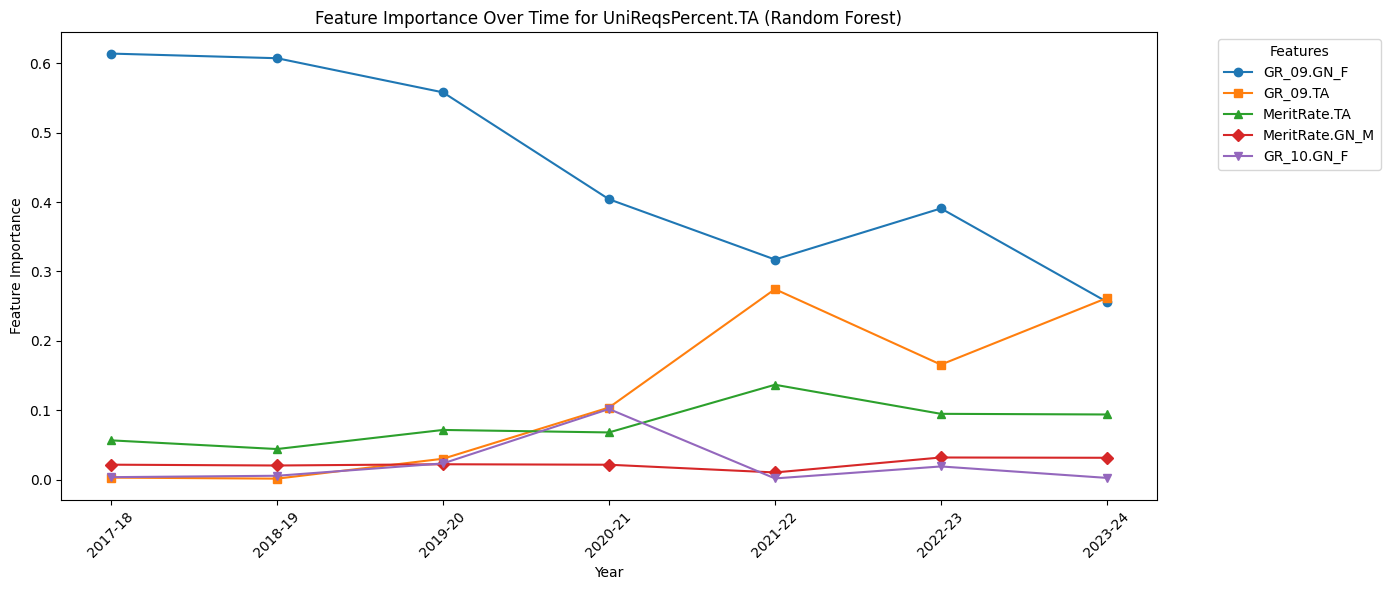

In [27]:
k = 5
all_top_features = plot_cv_feature_importance_rf(cv_models, top_n=k)

plot_top_k_features_rf(cv_models, target_variable=target_variable, k=k)
plot_feature_avg_variance_rf(
    cv_models, target_variable=target_variable, top_k_features=all_top_features[:k]
)
plot_feature_time_series_rf(
    cv_models, target_variable=target_variable, top_k_features=all_top_features[:k]
)

### Non Cross Validated Grad Rate


In [28]:
import modeling.utils.randomforest as rf

grad_rate = "RegHSDiplomaRate.TA"

all_rf_grad_rate_models = {}
for year, df in year_df_mapping.items():
    all_rf_grad_rate_models[year] = rf.train_random_forest_model(
        df, grad_rate, grad_rate_columns_to_drop, print_plot=False
    )

<Figure size 1400x600 with 0 Axes>

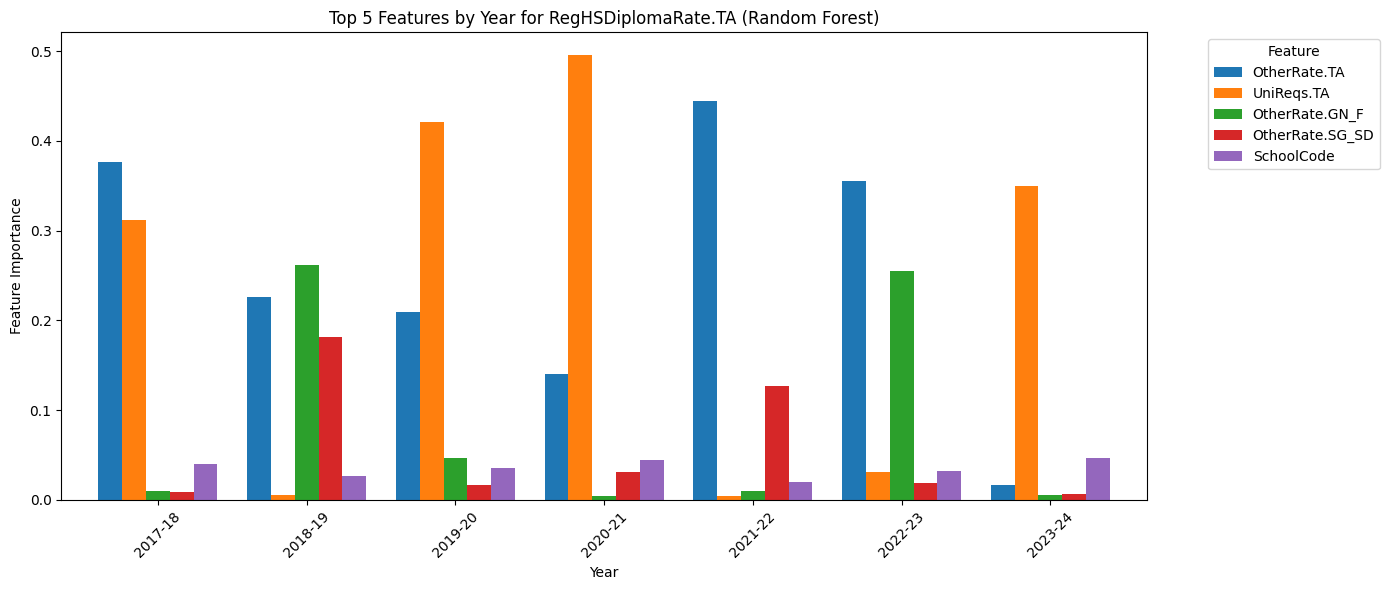

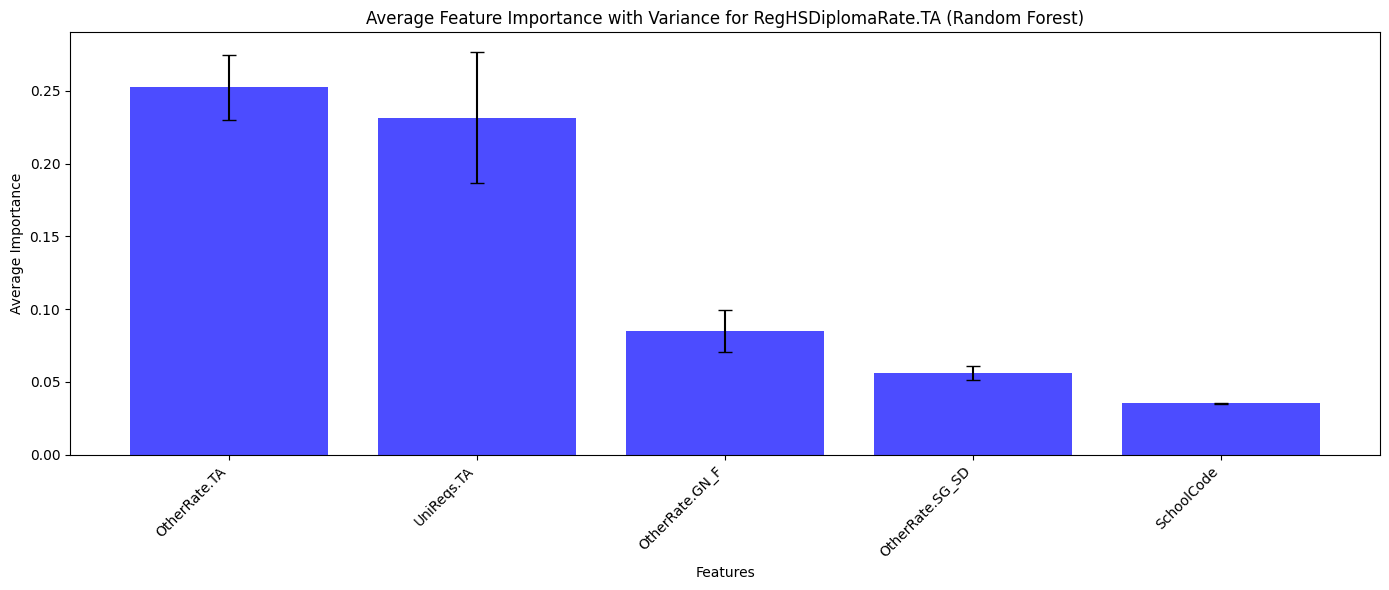

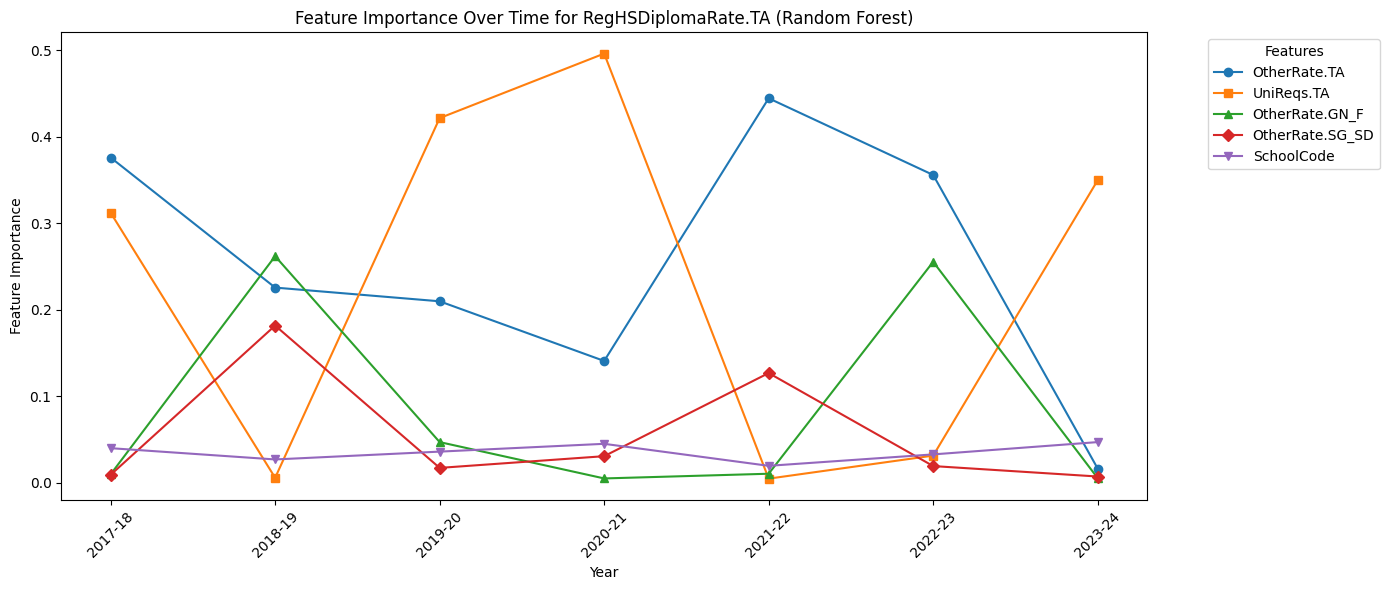

In [29]:
top_k_features_rf = rf.plot_top_k_features_rf(all_rf_grad_rate_models, grad_rate, k=5)

rf.plot_feature_avg_variance_rf(all_rf_grad_rate_models, grad_rate, top_k_features_rf)
rf.plot_feature_time_series_rf(all_rf_grad_rate_models, grad_rate, top_k_features_rf)

### Non Cross Validated CSU/UC Readiness Rate


In [30]:
import modeling.utils.randomforest as rf

csu_uc_rate = "UniReqsPercent.TA"
rf_model = "RandomForest"

all_rf_csu_uc_rate_models = {}
for year, df in year_df_mapping.items():
    all_rf_csu_uc_rate_models[year] = rf.train_random_forest_model(
        df, csu_uc_rate, csu_rate_columns_to_drop, print_plot=False
    )

<Figure size 1400x600 with 0 Axes>

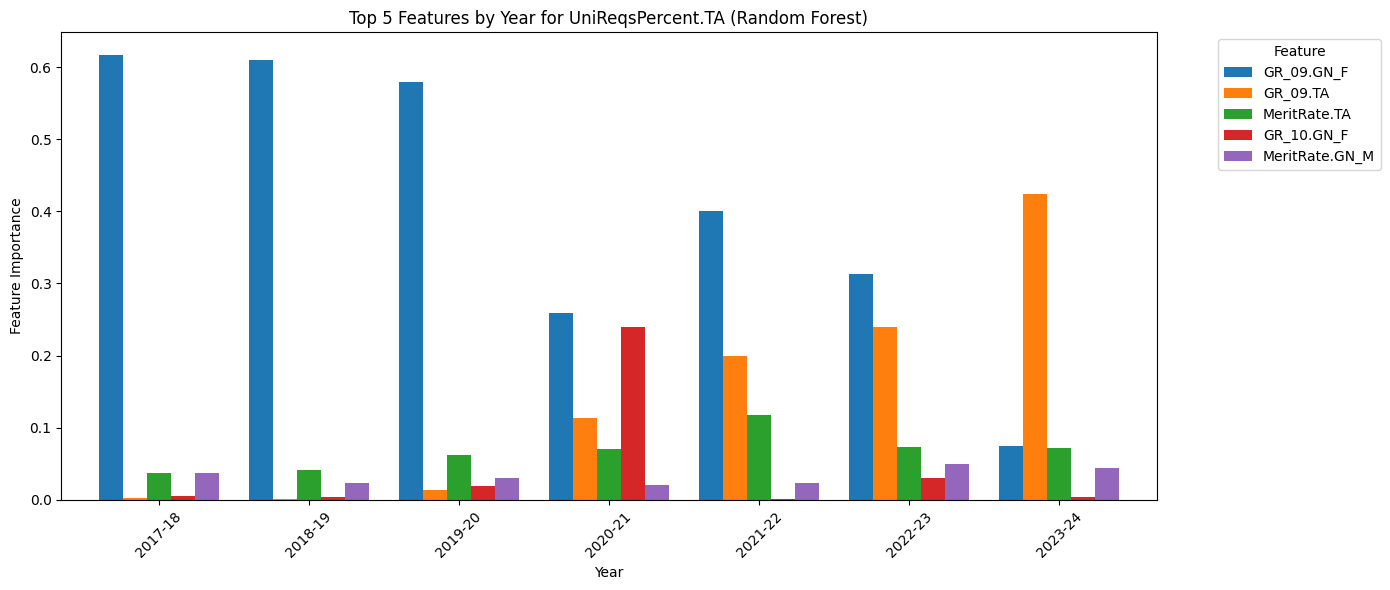

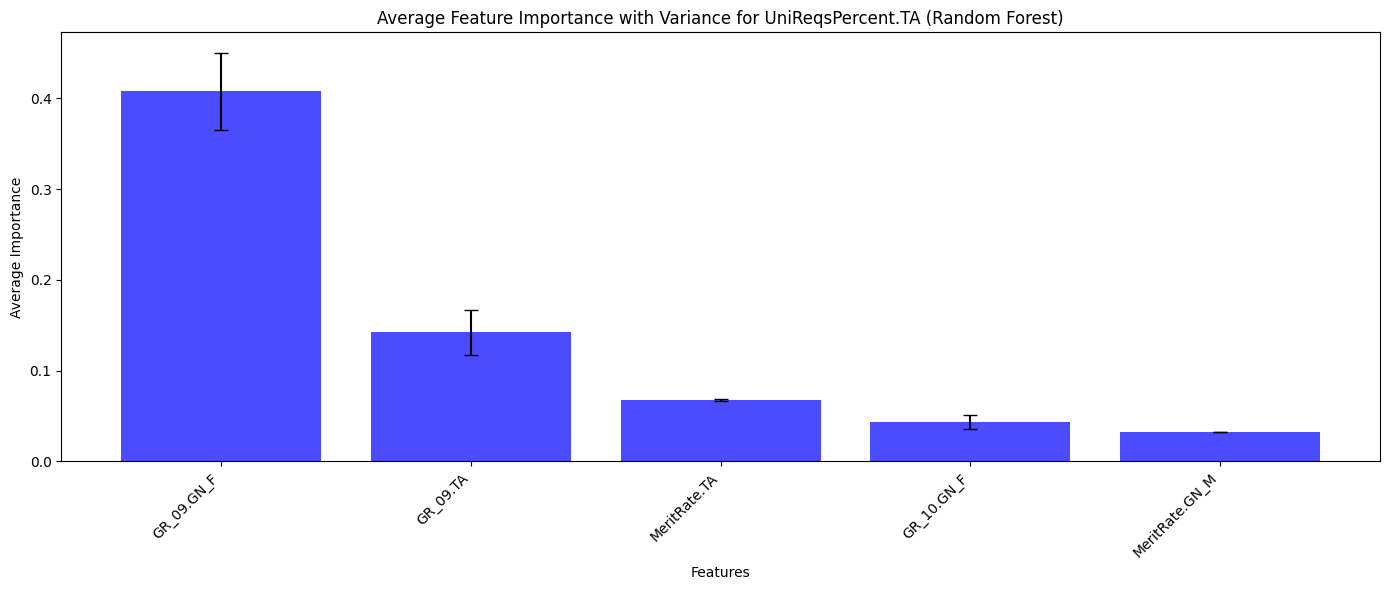

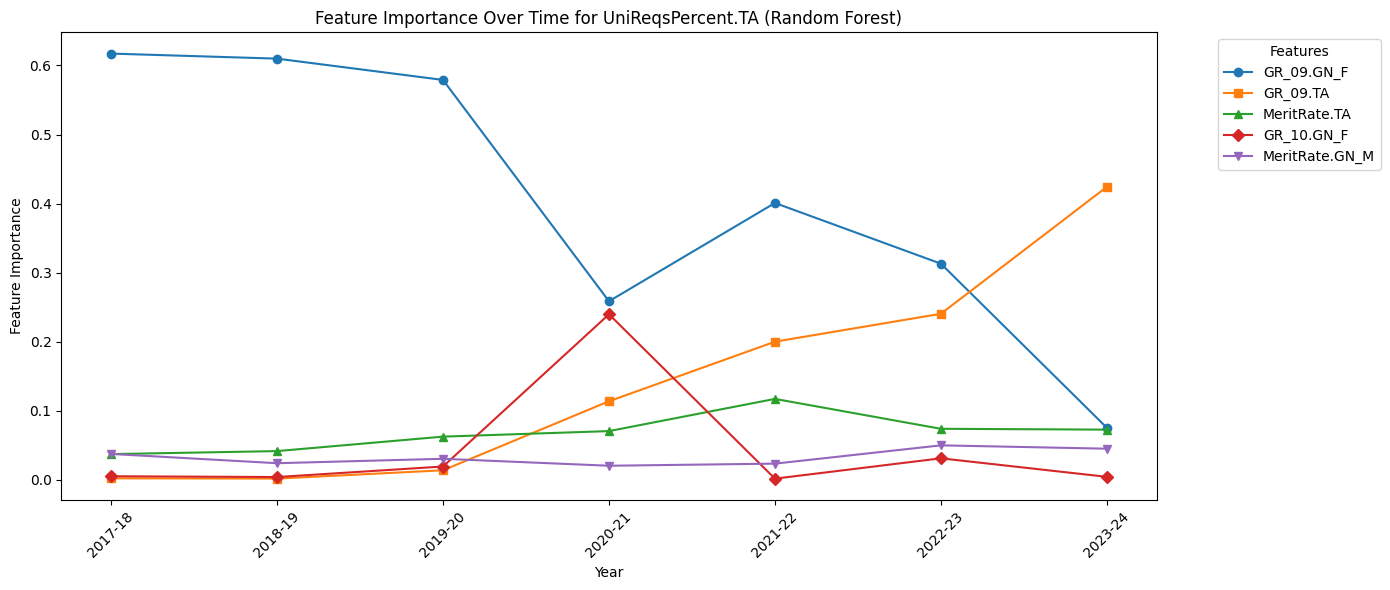

In [33]:
top_k_features_rf = rf.plot_top_k_features_rf(
    all_rf_csu_uc_rate_models, csu_uc_rate, k=5
)
rf.plot_feature_avg_variance_rf(
    all_rf_csu_uc_rate_models, csu_uc_rate, top_k_features_rf
)
rf.plot_feature_time_series_rf(
    all_rf_csu_uc_rate_models, csu_uc_rate, top_k_features_rf
)

In [ ]:
con.close()